In [1]:
import numpy as np
import tensorflow as tf
import h5py
import random
import time

# 数据准备

In [2]:
#读取数据
f=h5py.File('data/tdata1.h5','r')
data_x=f['x'][:]
data_y=f['y'][:]
#求取均值方差，归一化
x_=np.reshape(data_x,(-1,3))
y_=np.reshape(data_y,(-1,1))
x_mean=np.mean(x_,axis=0)
x_std=np.std(x_,axis=0)

y_mean=np.mean(y_,axis=0)
y_std=np.std(y_,axis=0)

data_x=(data_x-x_mean)/x_std
data_y=(data_y-y_mean)/y_std
#分配训练测试集
num=list(range(data_x.shape[0]))
num1=random.sample(num,200)
num2=set(num)-set(num1)
num2=list(num2)
num1.sort()


x_train=data_x[num2]
y_train=data_y[num2]

x_test=data_x[num1]
y_test=data_y[num1]
#生成批次
train_queue = tf.train.slice_input_producer([x_train,y_train],shuffle=None)
val_queue = tf.train.slice_input_producer([x_test,y_test],shuffle=None)
batch_xt,batch_yt=tf.train.shuffle_batch(train_queue,batch_size=16,capacity=500,min_after_dequeue=150)
batch_xv,batch_yv=tf.train.shuffle_batch(val_queue,batch_size=16,capacity=500,min_after_dequeue=150)

# 搭建模型

### 超参数设置

In [3]:
seq_length = batch_xt.shape[1]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = batch_xt.shape[0]  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = 1
input_dim = batch_xt.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 12 # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 4  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 10000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

### 搭建s2s

In [4]:
with tf.variable_scope('encoder'):

    # Encoder: inputs
    enc_inp = tf.placeholder(tf.float32, shape=(None, 10,3), name="inp")

    # Decoder: expected outputs
    expected_sparse_output = tf.placeholder(tf.float32, shape=(None, 10,1), name="expected_sparse_output")
    pharse=tf.placeholder(tf.bool,name='if_train')
    
   

    # encoder cell 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.contrib.rnn.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    
    enc_outputs, enc_memory = tf.nn.dynamic_rnn(cell,enc_inp,dtype=tf.float32)

with tf.variable_scope('decoder'):  
    decells=[]
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            decells.append(tf.contrib.rnn.GRUCell(hidden_dim))
            
    decell = tf.contrib.rnn.MultiRNNCell(decells)
    dec_state=enc_memory
    dec_inp=enc_outputs[:,-1,:]
    dec_outputs=[]
    #reshape expected_sparse_output
    w_h = tf.Variable(tf.random_normal([output_dim,hidden_dim]))
    b_h = tf.Variable(tf.random_normal([hidden_dim]))
    dec_inputs=[tf.matmul(expected_sparse_output[:,i,:],w_h)+b_h for i in range(seq_length)]
    
    for time_step in range(seq_length):
        if time_step>0:tf.get_variable_scope().reuse_variables()
        (dec_output,dec_state)=decell(dec_inp,dec_state)
        dec_inp = tf.where(tf.equal(pharse,True),dec_inputs[time_step],dec_output)
        dec_outputs.append(dec_output)
    
    # reshape seq2seq输出 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # 最终输出
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]
    reshaped_outputs=tf.convert_to_tensor(reshaped_outputs)
    reshaped_outputs=tf.transpose(reshaped_outputs,(1,0,2))

### 搭建损失函数 

In [5]:
# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    
    output_loss = tf.reduce_sum(tf.square(reshaped_outputs - expected_sparse_output))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
#     loss = output_loss + lambda_l2_reg * reg_loss
    loss = output_loss
    tf.summary.scalar('loss',loss)

with tf.variable_scope('acc'):
    acc=1-tf.reduce_mean(tf.sqrt(tf.square((reshaped_outputs*y_std+y_mean) - (expected_sparse_output*y_std+y_mean)))/tf.sqrt(tf.square(expected_sparse_output*y_std+y_mean)),axis=(0,1))[0]
    tf.summary.scalar('acc',acc)

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)
    merged_summary = tf.summary.merge_all()

### 训练模型

In [6]:
min_loss=1e10
sess=tf.Session()
# train_writer=tf.summary.FileWriter('D:/graph/wind-4-1/train/',sess.graph)
# test_writer = tf.summary.FileWriter('D:/graph/wind-4-1/test/', sess.graph)
saver=tf.train.Saver(max_to_keep=3)

init_op = tf.global_variables_initializer()
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord)
max_ac=0.5
t1=time.time()
for training_itr in range(nb_iters):
    x1, y1 = sess.run([batch_xt,batch_yt])
    feed_dict1 = {enc_inp: x1}
    feed_dict1.update({expected_sparse_output: y1})
    feed_dict1.update({pharse:True})
    _, loss1,acc1,summaries1 = sess.run([train_op, loss,acc,merged_summary], feed_dict1)

#     train_writer.add_summary(summaries1, training_itr)
    if training_itr %5==0:
#             saver.save(sess=sess, save_path='model/hand_landmark_v6.1_model/model.ckpt',global_step=(global_step + 1))
        mean_val_loss = 0

        x2,y2=sess.run([batch_xv,batch_yv])
        feed_dict2 = {enc_inp: x2}
        feed_dict2.update({expected_sparse_output: y2})
        feed_dict2.update({pharse:False})
        tt=time.time()
        loss2,acc2,summaries2,oout = sess.run([loss,acc,merged_summary,reshaped_outputs], feed_dict2)

        print('step: {} time:{}'.format(training_itr,time.time()-tt))
        print('train: loss: {} acc: {}  val: loss: {} acc: {}'.format(loss1,acc1,loss2,acc2))
        if acc2>max_ac:
            yy=y2*y_std+y_mean
            ppre=oout*y_std+y_mean
            max_ac=acc2
#         test_writer.add_summary(summaries2, training_itr)
        if loss1 < min_loss:
            min_loss=loss1
            saver.save(sess=sess, save_path='D:/model/twomonthes/model.ckpt',global_step=(training_itr + 1))
sess.close()
coord.request_stop()
print('final time: {}'.format(time.time()-t1))
    






step: 0 time:0.14749741554260254
train: loss: 391.54681396484375 acc: -1.6460590362548828  val: loss: 117.156005859375 acc: -0.6064255237579346
step: 5 time:0.0
train: loss: 58.532989501953125 acc: -1.241443157196045  val: loss: 28.24054718017578 acc: 0.16594505310058594
step: 10 time:0.0
train: loss: 22.179357528686523 acc: 0.2650367021560669  val: loss: 82.01847839355469 acc: 0.35285913944244385
step: 15 time:0.0030019283294677734
train: loss: 39.82048797607422 acc: 0.29268866777420044  val: loss: 105.89549255371094 acc: 0.3920673131942749
step: 20 time:0.0
train: loss: 11.080018997192383 acc: 0.6318703889846802  val: loss: 85.80674743652344 acc: 0.39071810245513916
step: 25 time:0.0
train: loss: 13.042516708374023 acc: 0.628836452960968  val: loss: 67.88426208496094 acc: 0.28744345903396606
step: 30 time:0.0
train: loss: 15.853347778320312 acc: 0.5683863162994385  val: loss: 13.08775806427002 acc: 0.6504001021385193
step: 35 time:0.0
train: loss: 17.28387451171875 acc: 0.62737905979

step: 300 time:0.003001689910888672
train: loss: 13.885286331176758 acc: 0.5151483416557312  val: loss: 12.67512321472168 acc: 0.7978612184524536
step: 305 time:0.003001689910888672
train: loss: 11.182228088378906 acc: 0.6703612208366394  val: loss: 5.882467269897461 acc: 0.7095698714256287
step: 310 time:0.0
train: loss: 6.918181419372559 acc: 0.7136713862419128  val: loss: 18.05196762084961 acc: 0.6773146986961365
step: 315 time:0.0
train: loss: 15.275524139404297 acc: 0.7930005192756653  val: loss: 9.205545425415039 acc: 0.6292689442634583
step: 320 time:0.0030014514923095703
train: loss: 5.421459197998047 acc: 0.8629103302955627  val: loss: 20.344423294067383 acc: 0.7204447388648987
step: 325 time:0.0030012130737304688
train: loss: 3.626352071762085 acc: 0.7479928135871887  val: loss: 4.352879524230957 acc: 0.6913034319877625
step: 330 time:0.017093896865844727
train: loss: 5.75339412689209 acc: 0.3928700089454651  val: loss: 11.812187194824219 acc: 0.2098260521888733
step: 335 tim

step: 595 time:0.0050029754638671875
train: loss: 22.22275161743164 acc: 0.5921027064323425  val: loss: 24.36035919189453 acc: 0.7432017922401428
step: 600 time:0.0030019283294677734
train: loss: 28.721263885498047 acc: 0.6503511667251587  val: loss: 2.2713663578033447 acc: 0.7662269473075867
step: 605 time:0.003001689910888672
train: loss: 14.661266326904297 acc: 0.7036715745925903  val: loss: 10.329866409301758 acc: 0.6818609237670898
step: 610 time:0.004002571105957031
train: loss: 14.178915023803711 acc: 0.8404832482337952  val: loss: 6.643684387207031 acc: 0.7721163034439087
step: 615 time:0.003001689910888672
train: loss: 6.576906204223633 acc: 0.5716956853866577  val: loss: 10.062825202941895 acc: 0.73405921459198
step: 620 time:0.0030014514923095703
train: loss: 19.73756980895996 acc: 0.7369397878646851  val: loss: 6.879045486450195 acc: 0.7366105914115906
step: 625 time:0.0
train: loss: 16.140975952148438 acc: 0.7886620759963989  val: loss: 16.072662353515625 acc: 0.6928875446

step: 880 time:0.0030019283294677734
train: loss: 2.142059326171875 acc: 0.6865249276161194  val: loss: 31.526561737060547 acc: 0.769376814365387
step: 885 time:0.0030019283294677734
train: loss: 3.45241641998291 acc: 0.824980616569519  val: loss: 23.206390380859375 acc: 0.7228066921234131
step: 890 time:0.003001689910888672
train: loss: 1.8413517475128174 acc: 0.5649936199188232  val: loss: 3.7064545154571533 acc: 0.5753799080848694
step: 895 time:0.0030019283294677734
train: loss: 1.1872807741165161 acc: 0.6060512661933899  val: loss: 24.191892623901367 acc: 0.7534422874450684
step: 900 time:0.0032448768615722656
train: loss: 4.343439102172852 acc: 0.5973016023635864  val: loss: 5.153684616088867 acc: 0.5809429883956909
step: 905 time:0.0
train: loss: 1.2856032848358154 acc: 0.6837601065635681  val: loss: 7.987757682800293 acc: 0.6159060001373291
step: 910 time:0.0
train: loss: 1.050310730934143 acc: 0.6817684769630432  val: loss: 4.072297096252441 acc: 0.8694444298744202
step: 915 t

step: 1180 time:0.004002094268798828
train: loss: 20.260326385498047 acc: 0.4855033755302429  val: loss: 13.251882553100586 acc: 0.7259706854820251
step: 1185 time:0.003002166748046875
train: loss: 4.745595932006836 acc: 0.7801249623298645  val: loss: 5.793349266052246 acc: 0.6242088079452515
step: 1190 time:0.0
train: loss: 14.386270523071289 acc: 0.3968240022659302  val: loss: 5.338696479797363 acc: 0.8006643056869507
step: 1195 time:0.0
train: loss: 7.824889659881592 acc: 0.6054330468177795  val: loss: 6.271995544433594 acc: 0.8049346208572388
step: 1200 time:0.0030019283294677734
train: loss: 8.0689697265625 acc: 0.6591631174087524  val: loss: 15.894071578979492 acc: 0.7405440807342529
step: 1205 time:0.0030019283294677734
train: loss: 3.54162335395813 acc: 0.7474013566970825  val: loss: 5.15281867980957 acc: 0.7588904500007629
step: 1210 time:0.015625953674316406
train: loss: 4.437909126281738 acc: 0.7957034111022949  val: loss: 2.229382276535034 acc: 0.6086629629135132
step: 1215

step: 1475 time:0.004002571105957031
train: loss: 2.0173261165618896 acc: 0.7742708325386047  val: loss: 21.15374755859375 acc: 0.838089108467102
step: 1480 time:0.0030024051666259766
train: loss: 2.3907694816589355 acc: 0.7017218470573425  val: loss: 8.891769409179688 acc: 0.8161356449127197
step: 1485 time:0.0
train: loss: 2.6369450092315674 acc: 0.7871863842010498  val: loss: 1.7193206548690796 acc: 0.7609091997146606
step: 1490 time:0.0
train: loss: 1.8359215259552002 acc: 0.7115446329116821  val: loss: 2.7443501949310303 acc: 0.7860591411590576
step: 1495 time:0.003002166748046875
train: loss: 1.3102614879608154 acc: 0.772623598575592  val: loss: 24.900150299072266 acc: 0.7851243019104004
step: 1500 time:0.003001689910888672
train: loss: 1.4070522785186768 acc: 0.7068926095962524  val: loss: 10.455228805541992 acc: 0.8541359901428223
step: 1505 time:0.003002166748046875
train: loss: 1.2279181480407715 acc: 0.7361587285995483  val: loss: 11.709918975830078 acc: 0.7959678173065186
s

step: 1780 time:0.0030019283294677734
train: loss: 5.095118522644043 acc: 0.8155101537704468  val: loss: 4.451663017272949 acc: 0.7304018139839172
step: 1785 time:0.015625476837158203
train: loss: 9.414924621582031 acc: 0.5745331645011902  val: loss: 8.467814445495605 acc: 0.826343834400177
step: 1790 time:0.0030019283294677734
train: loss: 5.233975410461426 acc: 0.4311586022377014  val: loss: 7.516942977905273 acc: 0.7947162389755249
step: 1795 time:0.0
train: loss: 7.827658653259277 acc: 0.6757131814956665  val: loss: 21.263877868652344 acc: 0.6952992677688599
step: 1800 time:0.0030019283294677734
train: loss: 14.310714721679688 acc: 0.575366735458374  val: loss: 5.827922821044922 acc: 0.6165485382080078
step: 1805 time:0.015625715255737305
train: loss: 8.407155990600586 acc: 0.6302130222320557  val: loss: 8.94308853149414 acc: 0.7656738758087158
step: 1810 time:0.0
train: loss: 7.696653366088867 acc: 0.7229074239730835  val: loss: 4.514029502868652 acc: 0.8851965665817261
step: 1815

step: 2075 time:0.003001689910888672
train: loss: 2.533998966217041 acc: 0.6717215180397034  val: loss: 11.149256706237793 acc: 0.7864757776260376
step: 2080 time:0.0
train: loss: 1.9910025596618652 acc: 0.8346338272094727  val: loss: 18.163713455200195 acc: 0.7694991827011108
step: 2085 time:0.0
train: loss: 0.8488659262657166 acc: 0.7800957560539246  val: loss: 1.8544199466705322 acc: 0.8073796033859253
step: 2090 time:0.015853166580200195
train: loss: 5.857549667358398 acc: 0.8145636916160583  val: loss: 3.7310423851013184 acc: 0.8436352610588074
step: 2095 time:0.00400233268737793
train: loss: 2.599337339401245 acc: 0.8150447607040405  val: loss: 15.135167121887207 acc: 0.8246349692344666
step: 2100 time:0.0
train: loss: 2.6761364936828613 acc: 0.8923125267028809  val: loss: 10.476320266723633 acc: 0.73121577501297
step: 2105 time:0.015626192092895508
train: loss: 2.210529088973999 acc: 0.8290526270866394  val: loss: 18.531875610351562 acc: 0.8715943098068237
step: 2110 time:0.0
tr

step: 2370 time:0.0030019283294677734
train: loss: 1.5256630182266235 acc: 0.82525634765625  val: loss: 1.896145224571228 acc: 0.7637963891029358
step: 2375 time:0.015956878662109375
train: loss: 5.534660339355469 acc: 0.7140494585037231  val: loss: 4.670705795288086 acc: 0.7312277555465698
step: 2380 time:0.0
train: loss: 3.7085514068603516 acc: 0.7696665525436401  val: loss: 19.1229248046875 acc: 0.8046857118606567
step: 2385 time:0.01610708236694336
train: loss: 2.786276340484619 acc: 0.8163400292396545  val: loss: 2.1388983726501465 acc: 0.896515965461731
step: 2390 time:0.0
train: loss: 2.268901824951172 acc: 0.8278855085372925  val: loss: 12.681147575378418 acc: 0.7361072301864624
step: 2395 time:0.0
train: loss: 2.5048670768737793 acc: 0.8819989562034607  val: loss: 6.013716220855713 acc: 0.8257608413696289
step: 2400 time:0.0
train: loss: 1.457382321357727 acc: 0.8780940175056458  val: loss: 30.34014892578125 acc: 0.6687015295028687
step: 2405 time:0.0
train: loss: 1.8275951147

step: 2670 time:0.0030012130737304688
train: loss: 19.055105209350586 acc: 0.5992276072502136  val: loss: 2.0736303329467773 acc: 0.7895888090133667
step: 2675 time:0.0
train: loss: 16.590951919555664 acc: 0.8198346495628357  val: loss: 4.130611419677734 acc: 0.8483582735061646
step: 2680 time:0.0
train: loss: 6.799002170562744 acc: 0.7971789240837097  val: loss: 18.20037841796875 acc: 0.7968840599060059
step: 2685 time:0.0
train: loss: 15.942484855651855 acc: 0.4935815930366516  val: loss: 6.070835113525391 acc: 0.8321210145950317
step: 2690 time:0.0030024051666259766
train: loss: 10.640875816345215 acc: 0.34599387645721436  val: loss: 10.430582046508789 acc: 0.8836637735366821
step: 2695 time:0.0
train: loss: 7.738192558288574 acc: 0.8236321210861206  val: loss: 14.132062911987305 acc: 0.7582093477249146
step: 2700 time:0.0
train: loss: 7.056191921234131 acc: 0.8824349045753479  val: loss: 2.2028491497039795 acc: 0.7748867273330688
step: 2705 time:0.0
train: loss: 5.9686102867126465 

step: 2980 time:0.004002571105957031
train: loss: 1.4673817157745361 acc: 0.6793831586837769  val: loss: 9.0184907913208 acc: 0.7470436692237854
step: 2985 time:0.0
train: loss: 1.343119740486145 acc: 0.43763113021850586  val: loss: 13.012529373168945 acc: 0.6857703924179077
step: 2990 time:0.0
train: loss: 0.9329715967178345 acc: 0.5111206769943237  val: loss: 13.222599983215332 acc: 0.8002001047134399
step: 2995 time:0.0
train: loss: 0.38873040676116943 acc: 0.7693008780479431  val: loss: 2.4139153957366943 acc: 0.844526469707489
step: 3000 time:0.00400233268737793
train: loss: 0.5551910400390625 acc: 0.7009769082069397  val: loss: 2.2977452278137207 acc: 0.7999346256256104
step: 3005 time:0.0
train: loss: 0.6298048496246338 acc: 0.7310754060745239  val: loss: 11.666220664978027 acc: 0.798356294631958
step: 3010 time:0.0
train: loss: 0.6443647146224976 acc: 0.6995476484298706  val: loss: 23.46636199951172 acc: 0.742072582244873
step: 3015 time:0.0
train: loss: 1.1669598817825317 acc:

step: 3290 time:0.0030019283294677734
train: loss: 3.7436978816986084 acc: 0.791752815246582  val: loss: 2.0417284965515137 acc: 0.8050150275230408
step: 3295 time:0.0030014514923095703
train: loss: 2.277735710144043 acc: 0.7838001251220703  val: loss: 9.729643821716309 acc: 0.8733716011047363
step: 3300 time:0.003002166748046875
train: loss: 9.015629768371582 acc: 0.8754110932350159  val: loss: 2.3932690620422363 acc: 0.7733826637268066
step: 3305 time:0.0
train: loss: 2.5413105487823486 acc: 0.9372755289077759  val: loss: 5.387879371643066 acc: 0.831327497959137
step: 3310 time:0.0030019283294677734
train: loss: 5.695169448852539 acc: 0.8031131625175476  val: loss: 9.939464569091797 acc: 0.5204722285270691
step: 3315 time:0.004002571105957031
train: loss: 5.450580596923828 acc: 0.5595742464065552  val: loss: 4.9298505783081055 acc: 0.8921037912368774
step: 3320 time:0.004002809524536133
train: loss: 0.979802668094635 acc: 0.8652145266532898  val: loss: 6.301164627075195 acc: 0.770233

step: 3595 time:0.0030014514923095703
train: loss: 2.0987868309020996 acc: 0.573471188545227  val: loss: 4.767495155334473 acc: 0.8368099927902222
step: 3600 time:0.0
train: loss: 1.4867422580718994 acc: 0.8563647270202637  val: loss: 2.2954115867614746 acc: 0.6994141936302185
step: 3605 time:0.00400233268737793
train: loss: 1.4004799127578735 acc: 0.7953484654426575  val: loss: 6.873678207397461 acc: 0.7541749477386475
step: 3610 time:0.004002809524536133
train: loss: 2.138930320739746 acc: 0.8212067484855652  val: loss: 1.5608782768249512 acc: 0.8198432922363281
step: 3615 time:0.00400233268737793
train: loss: 1.109386682510376 acc: 0.9197546243667603  val: loss: 12.2396240234375 acc: 0.8138723373413086
step: 3620 time:0.003001689910888672
train: loss: 2.6413938999176025 acc: 0.8658052682876587  val: loss: 1.7020397186279297 acc: 0.7454850077629089
step: 3625 time:0.0030019283294677734
train: loss: 1.1588748693466187 acc: 0.7943387627601624  val: loss: 14.150588989257812 acc: 0.82118

step: 3895 time:0.003001689910888672
train: loss: 4.524112224578857 acc: 0.7987179756164551  val: loss: 6.0525898933410645 acc: 0.7780788540840149
step: 3900 time:0.004002094268798828
train: loss: 3.9982118606567383 acc: 0.7242239713668823  val: loss: 2.491158962249756 acc: 0.7834170460700989
step: 3905 time:0.003999233245849609
train: loss: 8.419271469116211 acc: 0.8334016799926758  val: loss: 8.66229248046875 acc: 0.8406227827072144
step: 3910 time:0.004003047943115234
train: loss: 4.271079063415527 acc: 0.8672423362731934  val: loss: 4.932062149047852 acc: 0.7183065414428711
step: 3915 time:0.0030019283294677734
train: loss: 5.599017143249512 acc: 0.5938000082969666  val: loss: 4.591418266296387 acc: 0.8081234693527222
step: 3920 time:0.0
train: loss: 3.5201163291931152 acc: 0.7860273122787476  val: loss: 5.614156723022461 acc: 0.847793698310852
step: 3925 time:0.0
train: loss: 3.0965421199798584 acc: 0.8411827087402344  val: loss: 5.235904693603516 acc: 0.8135848045349121
step: 393

step: 4200 time:0.0030019283294677734
train: loss: 13.380413055419922 acc: 0.44305455684661865  val: loss: 10.960064888000488 acc: 0.798905611038208
step: 4205 time:0.0
train: loss: 13.232933044433594 acc: 0.4587000608444214  val: loss: 2.4471163749694824 acc: 0.8091524839401245
step: 4210 time:0.0020012855529785156
train: loss: 9.162510871887207 acc: 0.8147518634796143  val: loss: 2.1005640029907227 acc: 0.7973276972770691
step: 4215 time:0.0
train: loss: 13.606793403625488 acc: 0.7886098027229309  val: loss: 3.30739164352417 acc: 0.8309041261672974
step: 4220 time:0.001270294189453125
train: loss: 4.202683925628662 acc: 0.8008759021759033  val: loss: 1.8328537940979004 acc: 0.7911254167556763
step: 4225 time:0.0030019283294677734
train: loss: 9.931809425354004 acc: 0.7683138251304626  val: loss: 3.8103771209716797 acc: 0.8445671200752258
step: 4230 time:0.0
train: loss: 18.495342254638672 acc: 0.8524782061576843  val: loss: 4.94260311126709 acc: 0.8176203370094299
step: 4235 time:0.0

step: 4500 time:0.003002166748046875
train: loss: 1.9497629404067993 acc: 0.7882956862449646  val: loss: 4.162370681762695 acc: 0.8443853259086609
step: 4505 time:0.0
train: loss: 0.23399409651756287 acc: 0.8400793671607971  val: loss: 17.13747787475586 acc: 0.7687209844589233
step: 4510 time:0.015628814697265625
train: loss: 0.6500071883201599 acc: 0.8357175588607788  val: loss: 3.04801869392395 acc: 0.8720809817314148
step: 4515 time:0.0
train: loss: 2.8048970699310303 acc: 0.8133196830749512  val: loss: 3.8518168926239014 acc: 0.8490266799926758
step: 4520 time:0.0
train: loss: 3.6167962551116943 acc: 0.717923104763031  val: loss: 1.6109915971755981 acc: 0.7608692646026611
step: 4525 time:0.002001047134399414
train: loss: 1.643576979637146 acc: 0.7992025017738342  val: loss: 1.1095120906829834 acc: 0.7929384112358093
step: 4530 time:0.0011911392211914062
train: loss: 0.9325494766235352 acc: 0.7943972945213318  val: loss: 6.989137649536133 acc: 0.8417639136314392
step: 4535 time:0.0


step: 4810 time:0.003001689910888672
train: loss: 7.902046203613281 acc: 0.795872151851654  val: loss: 5.1980366706848145 acc: 0.6664074063301086
step: 4815 time:0.0020012855529785156
train: loss: 1.9654303789138794 acc: 0.8653257489204407  val: loss: 2.741225242614746 acc: 0.8570089936256409
step: 4820 time:0.0030014514923095703
train: loss: 0.8934230804443359 acc: 0.8863154053688049  val: loss: 3.044536590576172 acc: 0.8986026048660278
step: 4825 time:0.003002166748046875
train: loss: 1.5696260929107666 acc: 0.8847144842147827  val: loss: 1.974501609802246 acc: 0.8639883995056152
step: 4830 time:0.0030019283294677734
train: loss: 3.625842571258545 acc: 0.8744585514068604  val: loss: 3.8065242767333984 acc: 0.8318011164665222
step: 4835 time:0.0030019283294677734
train: loss: 4.784687042236328 acc: 0.8215159177780151  val: loss: 0.852836549282074 acc: 0.8654628992080688
step: 4840 time:0.003002166748046875
train: loss: 6.9138360023498535 acc: 0.85973060131073  val: loss: 4.82767295837

step: 5105 time:0.0030019283294677734
train: loss: 1.9827649593353271 acc: 0.7146696448326111  val: loss: 5.901110649108887 acc: 0.7178232669830322
step: 5110 time:0.003001689910888672
train: loss: 1.6795002222061157 acc: 0.8734003305435181  val: loss: 3.209519386291504 acc: 0.7603835463523865
step: 5115 time:0.003001689910888672
train: loss: 0.8885923624038696 acc: 0.8176224231719971  val: loss: 17.14181137084961 acc: 0.8768038153648376
step: 5120 time:0.004002809524536133
train: loss: 0.700704038143158 acc: 0.879266619682312  val: loss: 5.057854652404785 acc: 0.8930972218513489
step: 5125 time:0.0030019283294677734
train: loss: 0.4341796934604645 acc: 0.8667711019515991  val: loss: 2.6925864219665527 acc: 0.8114432692527771
step: 5130 time:0.004002094268798828
train: loss: 0.6942383050918579 acc: 0.6802796125411987  val: loss: 0.8336515426635742 acc: 0.8807955980300903
step: 5135 time:0.0030014514923095703
train: loss: 0.22469604015350342 acc: 0.8473772406578064  val: loss: 2.8180379

step: 5420 time:0.004003047943115234
train: loss: 3.2202930450439453 acc: 0.7939950823783875  val: loss: 7.5091471672058105 acc: 0.7839232683181763
step: 5425 time:0.0
train: loss: 5.310196876525879 acc: 0.6794353723526001  val: loss: 3.843484878540039 acc: 0.802028238773346
step: 5430 time:0.0
train: loss: 8.287402153015137 acc: 0.7635355591773987  val: loss: 2.7438387870788574 acc: 0.7847279906272888
step: 5435 time:0.0030019283294677734
train: loss: 2.148449420928955 acc: 0.8515259027481079  val: loss: 3.3399319648742676 acc: 0.8838862180709839
step: 5440 time:0.003376483917236328
train: loss: 5.526897430419922 acc: 0.7947108149528503  val: loss: 1.439339518547058 acc: 0.7844004034996033
step: 5445 time:0.0
train: loss: 9.66659164428711 acc: 0.8230553865432739  val: loss: 2.4480040073394775 acc: 0.8956360220909119
step: 5450 time:0.0030410289764404297
train: loss: 6.207032203674316 acc: 0.594551682472229  val: loss: 9.588056564331055 acc: 0.8554953336715698
step: 5455 time:0.0
train

step: 5730 time:0.0030019283294677734
train: loss: 1.9540565013885498 acc: 0.8033816814422607  val: loss: 7.702849864959717 acc: 0.8739728927612305
step: 5735 time:0.0
train: loss: 0.9279539585113525 acc: 0.8573660850524902  val: loss: 9.144964218139648 acc: 0.8910244703292847
step: 5740 time:0.0030019283294677734
train: loss: 1.6061995029449463 acc: 0.8337517380714417  val: loss: 4.834936618804932 acc: 0.8615332245826721
step: 5745 time:0.0
train: loss: 20.66670799255371 acc: 0.7749956846237183  val: loss: 5.211536884307861 acc: 0.8275482654571533
step: 5750 time:0.003002166748046875
train: loss: 8.340009689331055 acc: 0.8253318071365356  val: loss: 9.018659591674805 acc: 0.8300656080245972
step: 5755 time:0.0
train: loss: 21.42342185974121 acc: 0.6144905686378479  val: loss: 2.9796576499938965 acc: 0.7289837002754211
step: 5760 time:0.0
train: loss: 2.5569405555725098 acc: 0.7943424582481384  val: loss: 4.387338638305664 acc: 0.8162240982055664
step: 5765 time:0.017839431762695312
tr

step: 6030 time:0.003001689910888672
train: loss: 2.74855637550354 acc: 0.9309409856796265  val: loss: 0.9675654172897339 acc: 0.8657562136650085
step: 6035 time:0.0
train: loss: 3.12113094329834 acc: 0.8591587543487549  val: loss: 1.319014072418213 acc: 0.7975948452949524
step: 6040 time:0.0
train: loss: 1.063279151916504 acc: 0.8413925170898438  val: loss: 13.962606430053711 acc: 0.8312127590179443
step: 6045 time:0.0
train: loss: 1.5218660831451416 acc: 0.908972978591919  val: loss: 1.3134180307388306 acc: 0.8984273076057434
step: 6050 time:0.0030019283294677734
train: loss: 0.21887750923633575 acc: 0.8881410360336304  val: loss: 10.388360023498535 acc: 0.8713456988334656
step: 6055 time:0.0
train: loss: 0.5978325009346008 acc: 0.8111124038696289  val: loss: 3.9164042472839355 acc: 0.8575104475021362
step: 6060 time:0.0030591487884521484
train: loss: 0.6037406921386719 acc: 0.8248255252838135  val: loss: 1.262702226638794 acc: 0.8843075633049011
step: 6065 time:0.0
train: loss: 0.94

step: 6330 time:0.003002166748046875
train: loss: 10.488849639892578 acc: 0.7416178584098816  val: loss: 15.314615249633789 acc: 0.8386123776435852
step: 6335 time:0.0
train: loss: 3.183790445327759 acc: 0.904193639755249  val: loss: 2.4897921085357666 acc: 0.8235719203948975
step: 6340 time:0.0030019283294677734
train: loss: 3.4508895874023438 acc: 0.6448825597763062  val: loss: 1.8419445753097534 acc: 0.8472236394882202
step: 6345 time:0.0030019283294677734
train: loss: 4.170978546142578 acc: 0.9168014526367188  val: loss: 1.0668593645095825 acc: 0.8839762806892395
step: 6350 time:0.0030019283294677734
train: loss: 6.964713096618652 acc: 0.8132915496826172  val: loss: 3.0591936111450195 acc: 0.9198273420333862
step: 6355 time:0.0030019283294677734
train: loss: 2.6954407691955566 acc: 0.9051278233528137  val: loss: 1.677733063697815 acc: 0.7965297102928162
step: 6360 time:0.0030019283294677734
train: loss: 3.8978171348571777 acc: 0.7191277742385864  val: loss: 2.2271578311920166 acc: 

step: 6625 time:0.004002809524536133
train: loss: 0.24840334057807922 acc: 0.7611981630325317  val: loss: 8.031745910644531 acc: 0.9161279201507568
step: 6630 time:0.0
train: loss: 1.1435811519622803 acc: 0.5388085246086121  val: loss: 9.521061897277832 acc: 0.8783338665962219
step: 6635 time:0.003002166748046875
train: loss: 0.7236668467521667 acc: 0.8699169754981995  val: loss: 3.9857773780822754 acc: 0.8735755681991577
step: 6640 time:0.0030014514923095703
train: loss: 0.4376766085624695 acc: 0.8901866674423218  val: loss: 9.39592170715332 acc: 0.8553184866905212
step: 6645 time:0.0030014514923095703
train: loss: 1.5192439556121826 acc: 0.8804072737693787  val: loss: 2.5547749996185303 acc: 0.8723747730255127
step: 6650 time:0.0156252384185791
train: loss: 0.47525301575660706 acc: 0.8312260508537292  val: loss: 4.193970203399658 acc: 0.7650420069694519
step: 6655 time:0.0
train: loss: 1.2904338836669922 acc: 0.8233662843704224  val: loss: 3.782672643661499 acc: 0.8821436762809753
st

step: 6925 time:0.003002166748046875
train: loss: 5.266983985900879 acc: 0.8803287744522095  val: loss: 1.9990167617797852 acc: 0.8523526191711426
step: 6930 time:0.0
train: loss: 1.3043317794799805 acc: 0.9416236877441406  val: loss: 3.8772692680358887 acc: 0.8066511154174805
step: 6935 time:0.003001689910888672
train: loss: 1.3905880451202393 acc: 0.9346733093261719  val: loss: 3.030383348464966 acc: 0.7769861817359924
step: 6940 time:0.0
train: loss: 3.428807020187378 acc: 0.909525990486145  val: loss: 3.2321364879608154 acc: 0.7925085425376892
step: 6945 time:0.0030019283294677734
train: loss: 1.262723684310913 acc: 0.8847658634185791  val: loss: 0.6965670585632324 acc: 0.8775880932807922
step: 6950 time:0.0
train: loss: 0.6440377831459045 acc: 0.9415988326072693  val: loss: 1.5647947788238525 acc: 0.8845630288124084
step: 6955 time:0.0
train: loss: 1.761495590209961 acc: 0.8888537287712097  val: loss: 2.762056827545166 acc: 0.8721673488616943
step: 6960 time:0.0
train: loss: 0.492

step: 7225 time:0.003002166748046875
train: loss: 1.2768447399139404 acc: 0.8868607878684998  val: loss: 5.8831939697265625 acc: 0.8875712156295776
step: 7230 time:0.0
train: loss: 0.9767758846282959 acc: 0.8941565752029419  val: loss: 7.677516937255859 acc: 0.8358651399612427
step: 7235 time:0.0156252384185791
train: loss: 0.9987245798110962 acc: 0.7595022916793823  val: loss: 1.21340811252594 acc: 0.9092994332313538
step: 7240 time:0.0156252384185791
train: loss: 0.8584914207458496 acc: 0.8521960377693176  val: loss: 1.5655009746551514 acc: 0.860517144203186
step: 7245 time:0.0030014514923095703
train: loss: 1.1257814168930054 acc: 0.9087420701980591  val: loss: 5.43760871887207 acc: 0.9082893133163452
step: 7250 time:0.0
train: loss: 1.5121216773986816 acc: 0.9407460689544678  val: loss: 2.1016597747802734 acc: 0.8010488152503967
step: 7255 time:0.0
train: loss: 0.7639003992080688 acc: 0.8539733290672302  val: loss: 4.656700134277344 acc: 0.9011080861091614
step: 7260 time:0.0
train

step: 7525 time:0.0030019283294677734
train: loss: 3.9401023387908936 acc: 0.7499998211860657  val: loss: 4.12243127822876 acc: 0.8418278694152832
step: 7530 time:0.0030019283294677734
train: loss: 5.193994045257568 acc: 0.8425467014312744  val: loss: 0.6147526502609253 acc: 0.9091373682022095
step: 7535 time:0.0
train: loss: 1.5041766166687012 acc: 0.7480655908584595  val: loss: 1.100541591644287 acc: 0.8553592562675476
step: 7540 time:0.0030019283294677734
train: loss: 3.272238254547119 acc: 0.8572880625724792  val: loss: 1.9698376655578613 acc: 0.8913450837135315
step: 7545 time:0.003001689910888672
train: loss: 2.1393277645111084 acc: 0.8908966183662415  val: loss: 1.7600147724151611 acc: 0.9274291396141052
step: 7550 time:0.01582026481628418
train: loss: 4.725214004516602 acc: 0.7569705843925476  val: loss: 3.0634512901306152 acc: 0.9093409180641174
step: 7555 time:0.0
train: loss: 5.723800182342529 acc: 0.8853171467781067  val: loss: 1.5619759559631348 acc: 0.8811248540878296
ste

step: 7835 time:0.003001689910888672
train: loss: 16.059829711914062 acc: 0.6090792417526245  val: loss: 6.1380696296691895 acc: 0.6388508081436157
step: 7840 time:0.0
train: loss: 2.7719295024871826 acc: 0.908115804195404  val: loss: 1.5063700675964355 acc: 0.884468138217926
step: 7845 time:0.0
train: loss: 1.2270941734313965 acc: 0.8979140520095825  val: loss: 4.286270618438721 acc: 0.9206814765930176
step: 7850 time:0.0030019283294677734
train: loss: 5.609952926635742 acc: 0.8200073838233948  val: loss: 3.7405900955200195 acc: 0.8149330615997314
step: 7855 time:0.0030024051666259766
train: loss: 4.607295513153076 acc: 0.8996975421905518  val: loss: 0.6119807958602905 acc: 0.9045882225036621
step: 7860 time:0.0
train: loss: 13.197021484375 acc: 0.9062475562095642  val: loss: 1.3905444145202637 acc: 0.865070104598999
step: 7865 time:0.003054380416870117
train: loss: 13.366264343261719 acc: 0.2068486213684082  val: loss: 3.6963210105895996 acc: 0.7260264754295349
step: 7870 time:0.0020

step: 8135 time:0.004002809524536133
train: loss: 0.9123648405075073 acc: 0.8584891557693481  val: loss: 2.155223846435547 acc: 0.8277665376663208
step: 8140 time:0.0
train: loss: 0.2702659070491791 acc: 0.8786829113960266  val: loss: 5.367551326751709 acc: 0.8655447363853455
step: 8145 time:0.0
train: loss: 0.8443935513496399 acc: 0.8139046430587769  val: loss: 2.9028820991516113 acc: 0.8982701301574707
step: 8150 time:0.0
train: loss: 0.8615857362747192 acc: 0.7098323702812195  val: loss: 1.592289686203003 acc: 0.8362241983413696
step: 8155 time:0.0030019283294677734
train: loss: 1.462172508239746 acc: 0.7387310266494751  val: loss: 29.48489761352539 acc: 0.6652974486351013
step: 8160 time:0.015625953674316406
train: loss: 0.31236425042152405 acc: 0.854259192943573  val: loss: 1.522598147392273 acc: 0.8895191550254822
step: 8165 time:0.0
train: loss: 0.49876639246940613 acc: 0.8234078884124756  val: loss: 7.326972007751465 acc: 0.880597710609436
step: 8170 time:0.0
train: loss: 0.483

step: 8435 time:0.0030019283294677734
train: loss: 1.4625686407089233 acc: 0.8378690481185913  val: loss: 2.9264097213745117 acc: 0.876741886138916
step: 8440 time:0.0
train: loss: 6.855474948883057 acc: 0.8750733733177185  val: loss: 1.5873812437057495 acc: 0.835769534111023
step: 8445 time:0.0030019283294677734
train: loss: 4.089538097381592 acc: 0.7969224452972412  val: loss: 18.65704917907715 acc: 0.7676512598991394
step: 8450 time:0.0
train: loss: 1.3804960250854492 acc: 0.8446297645568848  val: loss: 4.107906818389893 acc: 0.7445879578590393
step: 8455 time:0.0030019283294677734
train: loss: 1.8077313899993896 acc: 0.8606466054916382  val: loss: 18.797792434692383 acc: 0.7938591241836548
step: 8460 time:0.0030019283294677734
train: loss: 0.955436646938324 acc: 0.9423512816429138  val: loss: 4.118372917175293 acc: 0.9072204828262329
step: 8465 time:0.0
train: loss: 1.1456129550933838 acc: 0.9412720799446106  val: loss: 22.065715789794922 acc: 0.8278533816337585
step: 8470 time:0.0

step: 8735 time:0.0030014514923095703
train: loss: 0.5582685470581055 acc: 0.8761193752288818  val: loss: 1.3313552141189575 acc: 0.9063164591789246
step: 8740 time:0.0
train: loss: 1.6915208101272583 acc: 0.8811846971511841  val: loss: 1.3264200687408447 acc: 0.8953093886375427
step: 8745 time:0.0
train: loss: 0.8086194396018982 acc: 0.8833602070808411  val: loss: 2.1736621856689453 acc: 0.8978628516197205
step: 8750 time:0.0
train: loss: 0.7067067623138428 acc: 0.7947510480880737  val: loss: 6.346366882324219 acc: 0.8832969069480896
step: 8755 time:0.003002166748046875
train: loss: 0.6306198239326477 acc: 0.8858863115310669  val: loss: 0.7253110408782959 acc: 0.9267133474349976
step: 8760 time:0.0
train: loss: 0.6312079429626465 acc: 0.7409583330154419  val: loss: 1.181487798690796 acc: 0.8107346296310425
step: 8765 time:0.015625715255737305
train: loss: 0.25732743740081787 acc: 0.8542013764381409  val: loss: 7.7947845458984375 acc: 0.9089728593826294
step: 8770 time:0.0
train: loss:

step: 9035 time:0.00400233268737793
train: loss: 0.5874280333518982 acc: 0.9259472489356995  val: loss: 1.1862894296646118 acc: 0.8329399824142456
step: 9040 time:0.0
train: loss: 1.073245644569397 acc: 0.9187642335891724  val: loss: 3.639493465423584 acc: 0.8700761198997498
step: 9045 time:0.017531871795654297
train: loss: 2.527336597442627 acc: 0.8804194927215576  val: loss: 2.1152429580688477 acc: 0.8310191035270691
step: 9050 time:0.0018639564514160156
train: loss: 4.859942436218262 acc: 0.6377526521682739  val: loss: 1.531465768814087 acc: 0.8688608407974243
step: 9055 time:0.0030014514923095703
train: loss: 2.937899589538574 acc: 0.601006269454956  val: loss: 1.5917749404907227 acc: 0.8425034880638123
step: 9060 time:0.0
train: loss: 3.497157573699951 acc: 0.6614717245101929  val: loss: 8.781161308288574 acc: 0.8182483911514282
step: 9065 time:0.017042160034179688
train: loss: 3.543534755706787 acc: 0.8144620656967163  val: loss: 2.2193477153778076 acc: 0.8914890885353088
step: 9

step: 9335 time:0.0030019283294677734
train: loss: 0.870387613773346 acc: 0.9128314852714539  val: loss: 1.667883038520813 acc: 0.8773421049118042
step: 9340 time:0.015625715255737305
train: loss: 1.6579760313034058 acc: 0.8547124266624451  val: loss: 3.394627571105957 acc: 0.8342943787574768
step: 9345 time:0.0
train: loss: 0.683772623538971 acc: 0.8499786853790283  val: loss: 3.1419217586517334 acc: 0.8501286506652832
step: 9350 time:0.0030019283294677734
train: loss: 1.4514665603637695 acc: 0.8706809878349304  val: loss: 1.5915366411209106 acc: 0.8464644551277161
step: 9355 time:0.003002166748046875
train: loss: 1.1007810831069946 acc: 0.9058165550231934  val: loss: 5.283885955810547 acc: 0.9050137400627136
step: 9360 time:0.0
train: loss: 0.756781816482544 acc: 0.915081262588501  val: loss: 4.3720831871032715 acc: 0.9398596882820129
step: 9365 time:0.0
train: loss: 4.5414323806762695 acc: 0.9038331508636475  val: loss: 5.493170738220215 acc: 0.8638928532600403
step: 9370 time:0.0
t

step: 9635 time:0.0030019283294677734
train: loss: 3.1701011657714844 acc: 0.9240928888320923  val: loss: 2.631981372833252 acc: 0.8757471442222595
step: 9640 time:0.0030019283294677734
train: loss: 3.571476936340332 acc: 0.7489173412322998  val: loss: 2.881920576095581 acc: 0.8140062689781189
step: 9645 time:0.0
train: loss: 2.5728631019592285 acc: 0.8887264132499695  val: loss: 1.614027976989746 acc: 0.898961067199707
step: 9650 time:0.015625953674316406
train: loss: 4.541191101074219 acc: 0.8506029844284058  val: loss: 2.5643510818481445 acc: 0.8660123348236084
step: 9655 time:0.0030019283294677734
train: loss: 1.9514293670654297 acc: 0.8583509922027588  val: loss: 1.1109095811843872 acc: 0.8933162689208984
step: 9660 time:0.0030019283294677734
train: loss: 0.8908993601799011 acc: 0.8698872327804565  val: loss: 2.9193501472473145 acc: 0.9306463599205017
step: 9665 time:0.0
train: loss: 2.6194019317626953 acc: 0.8906172513961792  val: loss: 3.7515578269958496 acc: 0.8003346920013428


step: 9935 time:0.003002166748046875
train: loss: 9.12830924987793 acc: 0.7489796876907349  val: loss: 4.10566520690918 acc: 0.8415284156799316
step: 9940 time:0.0
train: loss: 9.602048873901367 acc: 0.8600641489028931  val: loss: 4.173794269561768 acc: 0.8944326043128967
step: 9945 time:0.015625953674316406
train: loss: 7.332580089569092 acc: 0.4915887117385864  val: loss: 2.131753444671631 acc: 0.8539701700210571
step: 9950 time:0.0
train: loss: 4.490780830383301 acc: 0.8488063812255859  val: loss: 2.801038980484009 acc: 0.8602145910263062
step: 9955 time:0.0030014514923095703
train: loss: 2.1023356914520264 acc: 0.8435816764831543  val: loss: 1.7890594005584717 acc: 0.8786427974700928
step: 9960 time:0.003001689910888672
train: loss: 4.468084335327148 acc: 0.8664002418518066  val: loss: 1.4750568866729736 acc: 0.9068279266357422
step: 9965 time:0.0
train: loss: 1.8257173299789429 acc: 0.8851666450500488  val: loss: 15.185174942016602 acc: 0.8142108917236328
step: 9970 time:0.0030019

In [7]:
max_ac

0.94206655

In [8]:
yy[2]

array([[400.66],
       [390.42],
       [400.41],
       [400.59],
       [400.59],
       [400.6 ],
       [400.83],
       [400.03],
       [400.1 ],
       [400.64]], dtype=float32)

In [9]:
ppre[2]

array([[388.3565 ],
       [376.9084 ],
       [372.91177],
       [392.57382],
       [397.96802],
       [391.1403 ],
       [383.88507],
       [387.4459 ],
       [389.29532],
       [388.3732 ]], dtype=float32)

In [10]:
ac=np.mean(1-np.sqrt(np.square((yy*y_std+y_mean)-(ppre*y_std+y_mean)))/np.sqrt(np.square(yy*y_std+y_mean)),axis=0)

In [11]:
ac

array([[0.96502656],
       [0.9447634 ],
       [0.9414542 ],
       [0.97032356],
       [0.9695753 ],
       [0.9678531 ],
       [0.9462909 ],
       [0.9531091 ],
       [0.94567585],
       [0.81940895]], dtype=float32)

In [17]:
y=yy[:-1]
p=ppre[:-1]
y=np.reshape(y,(-1,1))
p=np.reshape(p,(-1,1))

In [18]:

import matplotlib.pyplot as plt
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei']  

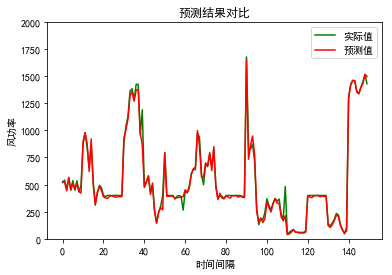

In [20]:
y=np.squeeze(y)
p=np.squeeze(p)
x=range(150)
plt.title('预测结果对比')
plt.ylim(0,2000)
plt.plot(x,y, color='green', label='实际值')
plt.plot(x, p, color='red', label='预测值')
plt.legend() # 显示图例
plt.xlabel('时间间隔')
plt.ylabel('风功率')
# plt.savefig("filename.png")
plt.show()

In [21]:
import pandas as pd

   

#字典中的key值即为csv中列名
dataframe = pd.DataFrame({'y_true':y,'y_predict':p})

#将DataFrame存储为csv,index表示是否显示行名，default=True
dataframe.to_csv("test.csv",index=False,sep=',')